In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats
import seaborn as sns
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.ensemble import VotingClassifier
from sklearn import svm,utils
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
ab=pd.read_pickle('../../Data/AB.pkl')
aab=pd.read_pickle('../../Data/AAB.pkl')
abb=pd.read_pickle('../../Data/ABB.pkl')

In [3]:
def prepare_dfs(df):
    """
    Input full ab,aab, or abb df 
    Output alpha and beta dfs with columns "V", "J" and (amino acid) "CDR3"
    """
    if 'a2_V' in df.columns: #aab cell -> include both alpha chains
        alpha1=df[['a1_V','a1_J','a1_aaSeqCDR3']]
        alpha2=df[['a2_V','a2_J','a2_aaSeqCDR3']]
        alpha=np.vstack((alpha1,alpha2)) #combine alpha-alpha pairs into one df
        beta=np.array((df[['b1_V','b1_J','b1_aaSeqCDR3']]))
    elif 'b2_V' in df.columns: #aab cell -> include both beta chains
        alpha=np.array((df[['a1_V','a1_J','a1_aaSeqCDR3']]))
        beta1=df[['b1_V','b1_J','b1_aaSeqCDR3']]
        beta2=df[['b2_V','b2_J','b2_aaSeqCDR3']]
        beta=np.vstack((beta1,beta2)) #combine beta-beta pairs into one df
    else: #ab cell
        alpha=np.array((df[['a1_V','a1_J','a1_aaSeqCDR3']]))
        beta=np.array((df[['b1_V','b1_J','b1_aaSeqCDR3']]))
    return pd.DataFrame(alpha,columns=['V','J','CDR3']),pd.DataFrame(beta,columns=['V','J','CDR3'])

In [4]:
def germline_genes(chain_type):
    """
    Provide list of germline region names 
    Output correct V and J germline regions for alpha or beta chains
    """
    beta_v_order=np.array(['1','2','3-1','4-1','5-1','6-1','7-1','4-2','6-2','3-2','4-3','6-3','7-2','8-1','5-2','6-4','7-3','8-2','5-3','9','10-1','11-1','12-1','10-2','11-2','12-2','6-5','7-4','5-4','6-6','7-5','5-5','6-7','7-6','5-6','6-8','7-7','5-7','6-9','7-8','5-8','7-9','13','10-3','11-3','12-3','12-4','12-5','14','15','16','17','18','19','20-1','21-1','22-1','23-1','24-1','25-1','26','27','28','29-1','30'])
    alpha_v_order=np.array(['1-1','1-2','2','3','4','5','6','7','8-1','9-1','10','11','12-1','8-2','8-3','13-1','12-2','8-4','8-5','13-2','14DV4','9-2','15','12-3','8-6','16','17','18','19','20','21','22','23DV6','24','25','26-1','8-7','27','28','29DV5','30','31','32','33','26-2','34','35','36DV7','37','38-1','38-2DV8','39','40','41'])
    beta_j_order=np.array(['1-1','1-2','1-3','1-4','1-5','1-6','2-1','2-2','2-2P','2-3','2-4','2-5','2-6','2-7'])
    alpha_j_order=np.array(list(map(str,range(1,62))))
    aa='GALSTNKVYRIQDFPEMWHC'  
    if chain_type=='A':
        order_v=alpha_v_order
        order_j=alpha_j_order
    elif chain_type=='B':
        order_v=beta_v_order
        order_j=beta_j_order
    return order_v,order_j,aa

In [5]:
def truncate_germline_names(data):    
    """
    Prepare gerlmine names s.t. the format matches the V/J region names provided names
    """
    if 'A' in data:
        which='A'
    else:
        which='B'
    if '*' in data:
        value=data[data.find(which)+2:data.find('*')]
    else:
        value=data[data.find(which)+2:]
    return value

In [6]:
def create_vector(df,v_order,j_order,aa):
    """
    Combine V, J and CDR3 features into single numeric vector
    """
    vs=np.zeros((1,len(v_order)))[0]
    js=np.zeros((1,len(j_order)))[0]
    vs[df.V]=1
    js[df.J]=1
    return np.hstack((vs,js,len(df.CDR3),[df['aa_'+x] for x in aa]))

In [7]:
def feature_to_vector(df):
    """
    Input alpha or beta df with columns V,J and CDR3
    Output numeric vectors for ML
    """
    chain_type=df.V.iloc[0][2] #'Get chain type (A' or 'B')
    v_order,j_order,aa=germline_genes(chain_type)
    df.V=[np.where(x==v_order)[0][0] for x in list(map(truncate_germline_names,df.V))]
    df.J=[np.where(x==j_order)[0][0] for x in list(map(truncate_germline_names,df.J))]
    for x in aa:
        df['aa_'+x]=[cdr3.count(x) for cdr3 in df.CDR3]
    df['Vector']=[create_vector(df.iloc[x],v_order,j_order,aa) for x in range(df.shape[0])]
    return np.array(pd.DataFrame(np.vstack(df.Vector)).drop_duplicates())

In [8]:
#Prepare alpha and beta datasets for ab,aab, and abb repertoires
datasets=np.empty((2,3),dtype=object)
for i,x in enumerate([ab,aab,abb]):
    a,b=prepare_dfs(x)
    datasets[0,i]=feature_to_vector(a)
    datasets[1,i]=feature_to_vector(b)

In [9]:
def run_ML(X,y,n_splits=5,n_repeats=10):
    """
    Input feature matrix X (TCRs as rows, features as columns)
    Output prediction accuraacy for trained ensemble machine learning algorithm on test set
    """
    kfolds = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats)
    accuracy=[]
    for train_index, test_index in kfolds.split(X, y):
        X_train,y_train=X[train_index],y[train_index]
        N=int(len(np.where(y_train==1)[0]))
        train_index=np.hstack((np.random.permutation(np.where(y_train==0)[0])[:N],np.random.permutation(np.where(y_train==1)[0])[:N]))
        X_train,y_train=X_train[train_index],y_train[train_index]
        clf1 = LogisticRegression(solver='lbfgs',max_iter=1000)
        clf2 = svm.SVC(kernel = 'poly',degree=1,probability=True)
        clf3 = MLPClassifier(hidden_layer_sizes=(19,11),alpha=0.125,max_iter=1000)
        clf = VotingClassifier(estimators=[('lr', clf1),('rfc', clf2),('mlp', clf3)],voting='soft')
        clf.fit(X_train,y_train)

        X_test,y_test=X[test_index],y[test_index]
        N=int(len(np.where(y_test==1)[0]))
        test_index=np.hstack((np.random.permutation(np.where(y_test==0)[0])[:N],np.random.permutation(np.where(y_test==1)[0])[:N]))
        X_test,y_test=X_test[test_index],y_test[test_index]
        preds=clf.predict(X_test)
        accuracy.append(accuracy_score(y_test, preds))
    print(stats.ttest_1samp(accuracy,0.5))
    return accuracy

In [10]:
#For each dataset, run ensemble machine learning classifier
data=[]
for aab_or_abb in [1,2]:
    for a_or_b in range(2):
        X=np.vstack((datasets[a_or_b,0],datasets[a_or_b,aab_or_abb]))
        y=np.hstack(([0]*datasets[a_or_b,0].shape[0],[1]*datasets[a_or_b,aab_or_abb].shape[0]))
        combined=np.hstack((X,y.reshape(y.shape[0],1)))
        unique_combined=np.array(pd.DataFrame(combined).drop_duplicates(keep=False,subset=np.arange(combined.shape[1]-1)))
        X=unique_combined[:,:-1]
        y=unique_combined[:,-1]
        data.append([a_or_b,aab_or_abb,run_ML(X,y,n_splits=5,n_repeats=10)])

Ttest_1sampResult(statistic=47.37102767605595, pvalue=1.3771131906857418e-42)
Ttest_1sampResult(statistic=7.692082037810244, pvalue=5.665078890981171e-10)
Ttest_1sampResult(statistic=4.437657937779258, pvalue=5.155399953960142e-05)
Ttest_1sampResult(statistic=26.820408416171095, pvalue=6.055936507286592e-31)


In [11]:
def make_boxplot(df):
    for x in df:
        if x[0]==0 and x[1]==1:
            dtype='a_aab'
        elif x[0]==1 and x[1]==1:
            dtype='b_aab'
        elif x[0]==0 and x[1]==2:
            dtype='a_abb'
        elif x[0]==1 and x[1]==2:
            dtype='b_abb'
        for accuracy in x[2]:
            try: 
                data=np.vstack((data,[dtype,accuracy]))
            except:
                data=[dtype,accuracy]
    df=pd.DataFrame(data,columns=['x','y'])
    df.y=df.y.astype(float)
    sns.boxplot(x='x',y='y',data=df,palette=['cornflowerblue','royalblue','lightcoral','firebrick'])
    plt.plot([-5,5],[.5,.5],'--k')
    plt.xticks(np.arange(4),[r'$\alpha \in \alpha\alpha\beta$',r'$\beta \in \alpha\alpha\beta$',   r'$\alpha \in \alpha\beta\beta$',r'$\beta \in \alpha\beta\beta$'],fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlim([-.5,3.5])
    plt.ylim([.49,.56])
    plt.xlabel('')
    plt.ylabel('')

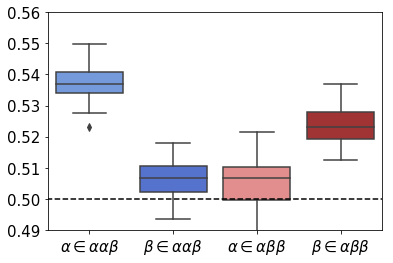

In [12]:
#plot boxplots showing classification accuracy for each dataset
make_boxplot(data)